# More Hot Plasma I Paper Comparisons

Checking for consistency in single-pulse examples of Paper I with Cargill. Seem to have some inconsistencies when it comes to bump in $\mathrm{EM}$ due to heating phase.

In [1]:
#Import needed modules
import sys
from imp import reload
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('/home/wtb2/Documents/EBTEL_C/bin/')
sys.path.append('/home/wtb2/Documents/EBTEL_analysis/src/')
import ebtel_wrapper as ew
import ebtel_run as ebr
reload(ebr)
reload(ew)

/usr/lib/python3/dist-packages/matplotlib/__init__.py:1175: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'ebtel_wrapper' from '/home/wtb2/Documents/EBTEL_C/bin/ebtel_wrapper.py'>

Set up a base dictionary. We'll modify it appropriately.

In [2]:
#input dictionary
config_dict = {'usage_option':'dem','rad_option':'rk','dem_option':'new','heat_flux_option':'classical',
              'solver':'euler','ic_mode':'st_eq','print_plasma_params':'True'}
config_dict['total_time'] = 5000
config_dict['tau'] = 1.0
config_dict['rka_error'] = 1.0e-6
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0/6.0
config_dict['h_back'] = 3.4e-6
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'uniform'
config_dict['t_end_switch'] = 'uniform'
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 0.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000
config_dict['amp_switch'] = 'uniform'
config_dict['amp0'] = 0.001
config_dict['amp1'] = 0.01
config_dict['alpha'] = 1.5
config_dict['loop_length'] = 40.0
config_dict['num_events'] = 1
config_dict['t_pulse_half'] = 100
config_dict['h_nano'] = 0.1
config_dict['output_file'] = '/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/hp1_compare_v2'

In [3]:
def run_and_print(input_dict,tau,h0,L,f,flux_opt,par_list_sf,par_list_tf,par_list_tf_i,run_inst):
    #set params
    input_dict['t_pulse_half'] = tau/2.0
    input_dict['h_nano'] = h0
    input_dict['loop_length'] = L
    input_dict['sat_limit'] = f
    input_dict['heat_flux_option'] = flux_opt
    input_dict['heat_species'] = 'electron'
    #print config file
    ew.print_xml_config(input_dict,config_file=input_dict['output_file']+'.xml')
    #single-fluid    
    #run model
    ew.run_ebtel('/home/wtb2/Documents/EBTEL_C/bin/','',config_file=input_dict['output_file']+'.xml')
    #save parameters to list
    temp = np.loadtxt(input_dict['output_file']+'_dem.txt')
    temp2 = np.loadtxt(input_dict['output_file']+'.txt')
    par_list_sf.append([temp[:,0],temp[:,4],temp2[:,0],temp2[:,1],temp2[:,2]])
    #two-fluid
    #--electron heating
    #run model
    run_inst.run_ebtel_single(input_dict['output_file']+'.xml',verbose=False)
    #save parameters to list
    temp = np.loadtxt(input_dict['output_file']+'_dem.txt')
    temp2 = np.loadtxt(input_dict['output_file']+'.txt')
    par_list_tf.append([temp[:,0],temp[:,4],temp2[:,0],temp2[:,1],temp2[:,3]])
    #--ion heating
    #print config file
    input_dict['heat_species'] = 'ion'
    ew.print_xml_config(input_dict,config_file=input_dict['output_file']+'.xml')
    #run model
    run_inst.run_ebtel_single(input_dict['output_file']+'.xml',verbose=False)
    #save parameters to list
    temp = np.loadtxt(input_dict['output_file']+'_dem.txt')
    temp2 = np.loadtxt(input_dict['output_file']+'.txt')
    par_list_tf_i.append([temp[:,0],temp[:,4],temp2[:,0],temp2[:,1],temp2[:,3]])

We will be varying the pulse duration $\tau_H$, maximum heating rate $H_0$, and loop half-length $L$. In all cases, we will conserve the total energy density injected into the loop $q=10$ erg cm$^{-3}$ s$^{-1}$, which for triangular pulses, is written as $q=\tau_HH_0/2$.

First, instantiate the Runner class for the two-fluid model. We only need to do this once.

In [4]:
runner = ebr.Runner('/home/wtb2/Documents/EBTEL-2fluid_repo/bin/','')

## Section 1: Vary Pulse Duration

Here, we will look at several different values for the pulse duration $\tau_H=20,40,200,500$ s and see how this affects the resulting $\mathrm{EM}$.

In [5]:
tau_h = [20,40,200,500]
results_tau_sf = []
results_tau_tf = []
results_tau_tf_i = []
for t in tau_h:
    run_and_print(config_dict,t,20.0/t,40.0,1,'classical',results_tau_sf,results_tau_tf,results_tau_tf_i,runner)

Plot the resulting emission measures for all values of $\tau$.

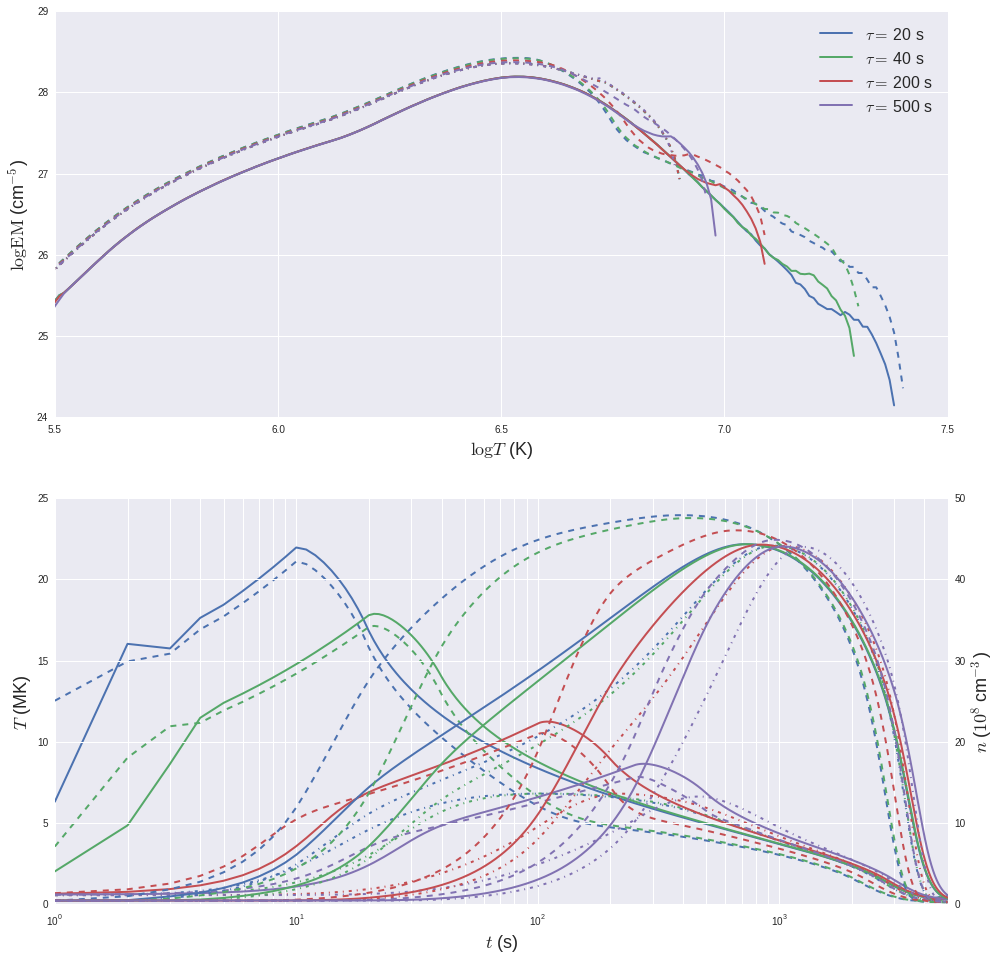

In [11]:
fig,axes = plt.subplots(2,1,figsize=(16,16))
ax_n = axes[1].twinx()
for i in range(len(results_tau_sf)):
    #EM plots
    axes[0].plot(results_tau_sf[i][0],results_tau_sf[i][1],color=sns.color_palette()[i],linewidth=2,
            label=r'$\tau=$ %d s'%tau_h[i])
    axes[0].plot(results_tau_tf[i][0],results_tau_tf[i][1],color=sns.color_palette()[i],linewidth=2,linestyle='--')
    axes[0].plot(results_tau_tf_i[i][0],results_tau_tf_i[i][1],color=sns.color_palette()[i],linewidth=2,linestyle='-.')
    #T profiles
    axes[1].plot(results_tau_sf[i][2],results_tau_sf[i][3]/1e+6,color=sns.color_palette()[i],linewidth=2)
    axes[1].plot(results_tau_tf[i][2],results_tau_tf[i][3]/1e+6,color=sns.color_palette()[i],linewidth=2,linestyle='--')
    axes[1].plot(results_tau_tf_i[i][2],results_tau_tf_i[i][3]/1e+6,color=sns.color_palette()[i],linewidth=2,linestyle='-.')
    #n profiles
    ax_n.plot(results_tau_sf[i][2],results_tau_sf[i][4]/1e+8,color=sns.color_palette()[i],linewidth=2)
    ax_n.plot(results_tau_tf[i][2],results_tau_tf[i][4]/1e+8,color=sns.color_palette()[i],linewidth=2,linestyle='--')
    ax_n.plot(results_tau_tf_i[i][2],results_tau_tf_i[i][4]/1e+8,color=sns.color_palette()[i],linewidth=2,linestyle='-.')
axes[0].set_xlabel(r'$\log{T}$ (K)',fontsize=18)
axes[0].set_ylabel(r'$\log{\mathrm{EM}}$ (cm$^{-5}$)',fontsize=18)
axes[1].set_xlabel(r'$t$ (s)',fontsize=18)
axes[1].set_ylabel(r'$T$ (MK)',fontsize=18)
ax_n.set_ylabel(r'$n$ ($10^8 $cm$^{-3}$)',fontsize=18)
axes[1].set_xscale('log')
axes[1].set_xlim([0,config_dict['total_time']])
ax_n.set_xscale('log')
ax_n.set_xlim([0,config_dict['total_time']])
axes[0].set_xlim([5.5,7.5])
axes[0].set_ylim([24,29])
axes[0].legend(fontsize=16,loc='best')

## Section 2: Vary Heating Amplitude

Now, we'll look at a couple of different values of the heating rate, $H_0=0.05,0.1,0.2,0.5$ erg cm$^{-3}$ s$^{-1}$. Here, I have **not** conserved the total event energy and instead kept $\tau_H=200$ s. This seems to be what has been done in the draft of Paper I and will need clarification in the final draft. 

In [7]:
h0 = [.05,.1,.2,.5]
results_h0_sf = []
results_h0_tf = []
results_h0_tf_i = []
for h in h0:
    run_and_print(config_dict,200.0,h,40.0,1,'classical',results_h0_sf,results_h0_tf,results_h0_tf_i,runner)

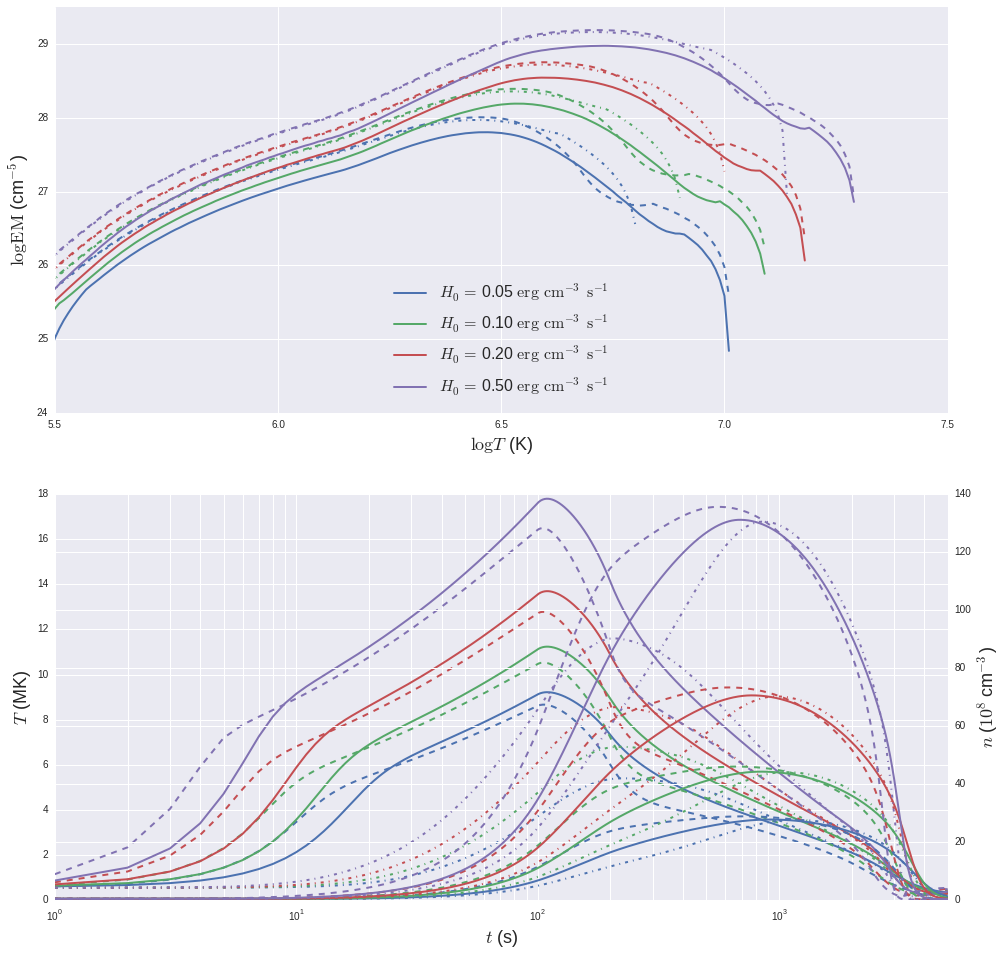

In [8]:
fig,axes = plt.subplots(2,1,figsize=(16,16))
ax_n = axes[1].twinx()
for i in range(len(results_h0_sf)):
    #EM plots
    axes[0].plot(results_h0_sf[i][0],results_h0_sf[i][1],color=sns.color_palette()[i],linewidth=2,
            label=r'$H_0=$ %.2f $\mathrm{erg}\,\mathrm{cm}^{-3}\,\mathrm{s}^{-1}$'%h0[i])
    axes[0].plot(results_h0_tf[i][0],results_h0_tf[i][1],color=sns.color_palette()[i],linewidth=2,linestyle='--')
    axes[0].plot(results_h0_tf_i[i][0],results_h0_tf_i[i][1],color=sns.color_palette()[i],linewidth=2,linestyle='-.')
    #T profiles
    axes[1].plot(results_h0_sf[i][2],results_h0_sf[i][3]/1e+6,color=sns.color_palette()[i],linewidth=2)
    axes[1].plot(results_h0_tf[i][2],results_h0_tf[i][3]/1e+6,color=sns.color_palette()[i],linewidth=2,linestyle='--')
    axes[1].plot(results_h0_tf_i[i][2],results_h0_tf_i[i][3]/1e+6,color=sns.color_palette()[i],linewidth=2,linestyle='-.')
    #n profiles
    ax_n.plot(results_h0_sf[i][2],results_h0_sf[i][4]/1e+8,color=sns.color_palette()[i],linewidth=2)
    ax_n.plot(results_h0_tf[i][2],results_h0_tf[i][4]/1e+8,color=sns.color_palette()[i],linewidth=2,linestyle='--')
    ax_n.plot(results_h0_tf_i[i][2],results_h0_tf_i[i][4]/1e+8,color=sns.color_palette()[i],linewidth=2,linestyle='-.')
axes[0].set_xlabel(r'$\log{T}$ (K)',fontsize=18)
axes[0].set_ylabel(r'$\log{\mathrm{EM}}$ (cm$^{-5}$)',fontsize=18)
axes[1].set_xlabel(r'$t$ (s)',fontsize=18)
axes[1].set_ylabel(r'$T$ (MK)',fontsize=18)
ax_n.set_ylabel(r'$n$ ($10^8 $cm$^{-3}$)',fontsize=18)
axes[1].set_xscale('log')
axes[1].set_xlim([0,config_dict['total_time']])
ax_n.set_xscale('log')
ax_n.set_xlim([0,config_dict['total_time']])
axes[0].set_xlim([5.5,7.5])
axes[0].set_ylim([24,29.5])
axes[0].legend(fontsize=16,loc='best')

## Section 3: Vary Loop Length

Here, we'll simply vary the loop half-length for three different values of $L=20,40,75$ Mm to see how this affects $\mathrm{EM}$. In the nanoflare train cases, I've found that this steepens/truncates the cool side because the cooling timescale is roughly $\tau_{cool}\propto L$ (i.e. it takes longer for longer loops to cool).

In [12]:
loop_length = [20.0,40.0,75.0]
results_ll_sf = []
results_ll_tf  = []
results_ll_tf_i = []
for l in loop_length:
    run_and_print(config_dict,200.0,0.1,l,1,'classical',results_ll_sf,results_ll_tf,results_ll_tf_i,runner)

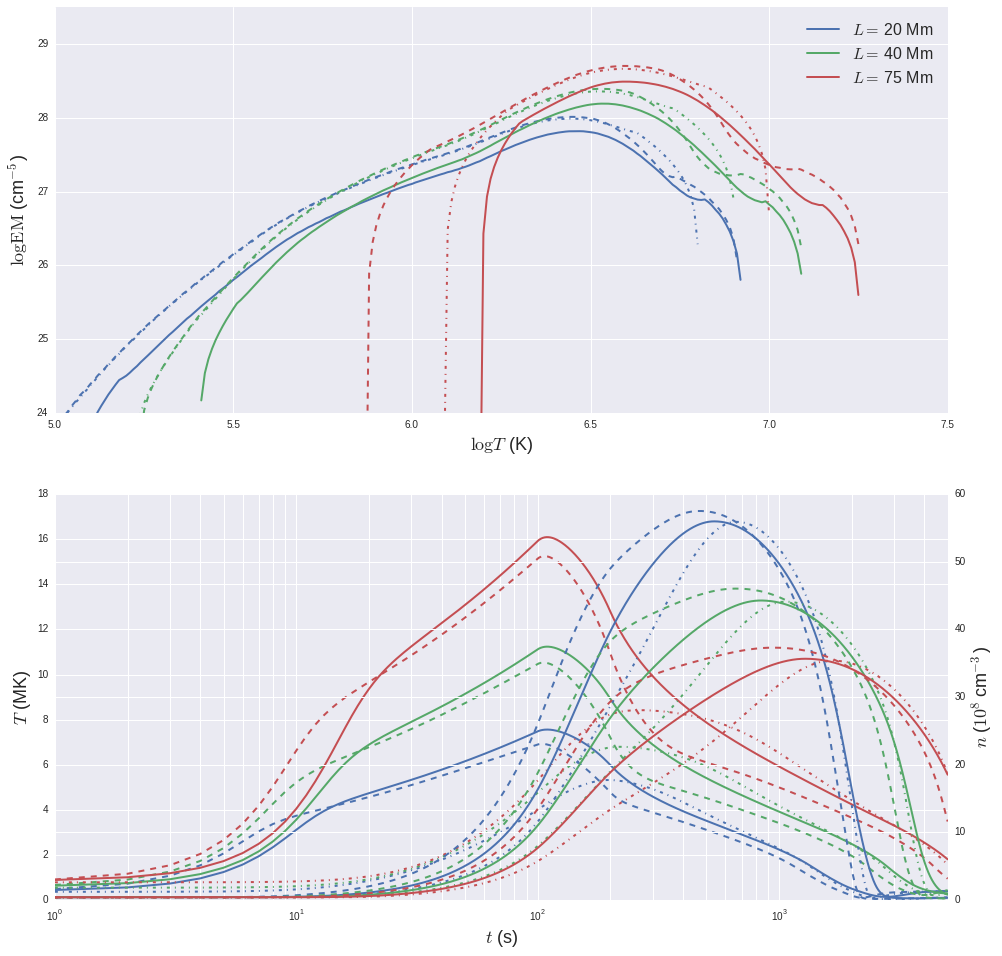

In [13]:
fig,axes = plt.subplots(2,1,figsize=(16,16))
ax_n = axes[1].twinx()
for i in range(len(results_ll_sf)):
    #EM plots
    axes[0].plot(results_ll_sf[i][0],results_ll_sf[i][1],color=sns.color_palette()[i],linewidth=2,
            label=r'$L=$ %d Mm'%loop_length[i])
    axes[0].plot(results_ll_tf[i][0],results_ll_tf[i][1],color=sns.color_palette()[i],linewidth=2,linestyle='--')
    axes[0].plot(results_ll_tf_i[i][0],results_ll_tf_i[i][1],color=sns.color_palette()[i],linewidth=2,linestyle='-.')
    #T profiles
    axes[1].plot(results_ll_sf[i][2],results_ll_sf[i][3]/1e+6,color=sns.color_palette()[i],linewidth=2)
    axes[1].plot(results_ll_tf[i][2],results_ll_tf[i][3]/1e+6,color=sns.color_palette()[i],linewidth=2,linestyle='--')
    axes[1].plot(results_ll_tf_i[i][2],results_ll_tf_i[i][3]/1e+6,color=sns.color_palette()[i],linewidth=2,linestyle='-.')
    #n profiles
    ax_n.plot(results_ll_sf[i][2],results_ll_sf[i][4]/1e+8,color=sns.color_palette()[i],linewidth=2)
    ax_n.plot(results_ll_tf[i][2],results_ll_tf[i][4]/1e+8,color=sns.color_palette()[i],linewidth=2,linestyle='--')
    ax_n.plot(results_ll_tf_i[i][2],results_ll_tf_i[i][4]/1e+8,color=sns.color_palette()[i],linewidth=2,linestyle='-.')
axes[0].set_xlabel(r'$\log{T}$ (K)',fontsize=18)
axes[0].set_ylabel(r'$\log{\mathrm{EM}}$ (cm$^{-5}$)',fontsize=18)
axes[1].set_xlabel(r'$t$ (s)',fontsize=18)
axes[1].set_ylabel(r'$T$ (MK)',fontsize=18)
ax_n.set_ylabel(r'$n$ ($10^8 $cm$^{-3}$)',fontsize=18)
axes[1].set_xscale('log')
axes[1].set_xlim([0,config_dict['total_time']])
ax_n.set_xscale('log')
ax_n.set_xlim([0,config_dict['total_time']])
axes[0].set_xlim([5,7.5])
axes[0].set_ylim([24,29.5])
axes[0].legend(fontsize=16,loc='best')

## Section 4: Change Heat Flux Limiter

Finally, in this section, we'll alter the flux limiter $\beta=1/6,1/30$ and also look at the case where the flux limiter is turned off (i.e.$\beta\to\infty$).

In [14]:
flux_lim = [[1.0/6.0,'limited'],[1.0/30.0,'limited'],[1.0,'limited'],[1.0,'classical']]
results_flux_lim_sf = []
results_flux_lim_tf = []
results_flux_lim_tf_i = []
for fl in flux_lim:
    run_and_print(config_dict,200.0,0.1,40.0,fl[0],fl[1],results_flux_lim_sf,results_flux_lim_tf,
                  results_flux_lim_tf_i,runner)

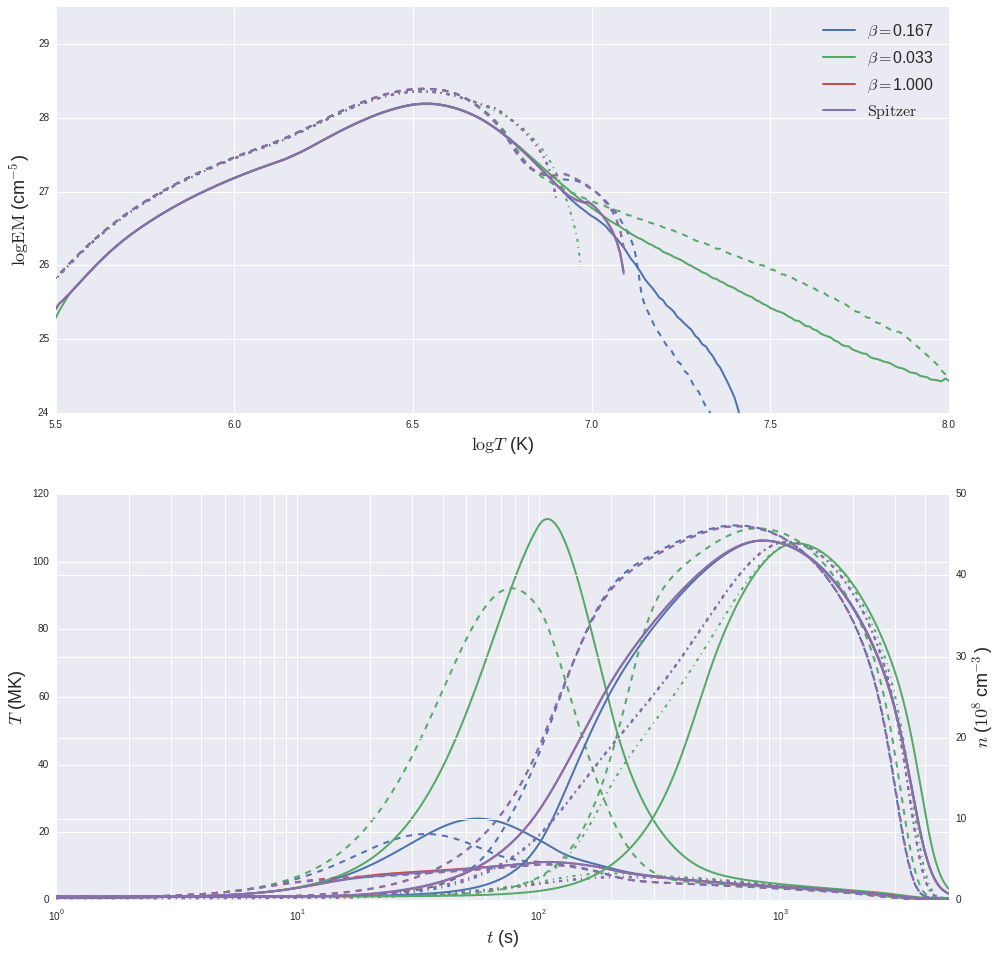

In [17]:
fig,axes = plt.subplots(2,1,figsize=(16,16))
ax_n = axes[1].twinx()
for i in range(len(results_flux_lim_sf)):
    if flux_lim[i][1] == 'classical':
        plab = r'$\mathrm{Spitzer}$'
    else:
        plab = r'$\beta=$%.3f'%flux_lim[i][0]
    #EM plots
    axes[0].plot(results_flux_lim_sf[i][0],results_flux_lim_sf[i][1],color=sns.color_palette()[i],linewidth=2,
            label=plab)
    axes[0].plot(results_flux_lim_tf[i][0],results_flux_lim_tf[i][1],color=sns.color_palette()[i],linewidth=2,linestyle='--')
    axes[0].plot(results_flux_lim_tf_i[i][0],results_flux_lim_tf_i[i][1],color=sns.color_palette()[i],linewidth=2,linestyle='-.')
    #T profiles
    axes[1].plot(results_flux_lim_sf[i][2],results_flux_lim_sf[i][3]/1e+6,color=sns.color_palette()[i],linewidth=2)
    axes[1].plot(results_flux_lim_tf[i][2],results_flux_lim_tf[i][3]/1e+6,color=sns.color_palette()[i],linewidth=2,linestyle='--')
    axes[1].plot(results_flux_lim_tf_i[i][2],results_flux_lim_tf_i[i][3]/1e+6,color=sns.color_palette()[i],linewidth=2,linestyle='-.')
    #n profiles
    ax_n.plot(results_flux_lim_sf[i][2],results_flux_lim_sf[i][4]/1e+8,color=sns.color_palette()[i],linewidth=2)
    ax_n.plot(results_flux_lim_tf[i][2],results_flux_lim_tf[i][4]/1e+8,color=sns.color_palette()[i],linewidth=2,linestyle='--')
    ax_n.plot(results_flux_lim_tf_i[i][2],results_flux_lim_tf_i[i][4]/1e+8,color=sns.color_palette()[i],linewidth=2,linestyle='-.')
axes[0].set_xlabel(r'$\log{T}$ (K)',fontsize=18)
axes[0].set_ylabel(r'$\log{\mathrm{EM}}$ (cm$^{-5}$)',fontsize=18)
axes[1].set_xlabel(r'$t$ (s)',fontsize=18)
axes[1].set_ylabel(r'$T$ (MK)',fontsize=18)
ax_n.set_ylabel(r'$n$ ($10^8 $cm$^{-3}$)',fontsize=18)
axes[1].set_xscale('log')
axes[1].set_xlim([0,config_dict['total_time']])
ax_n.set_xscale('log')
ax_n.set_xlim([0,config_dict['total_time']])
axes[0].set_xlim([5.5,8])
axes[0].set_ylim([24,29.5])
axes[0].legend(fontsize=16,loc='best')